# Gibbs Sampling from errors-in model


### Setup

In [93]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.special import gammaln
import corner
from scipy.stats import invgamma
import seaborn as sns
from dataclasses import dataclass


## Model with intrinsic dispersion (Trotta's problem version)

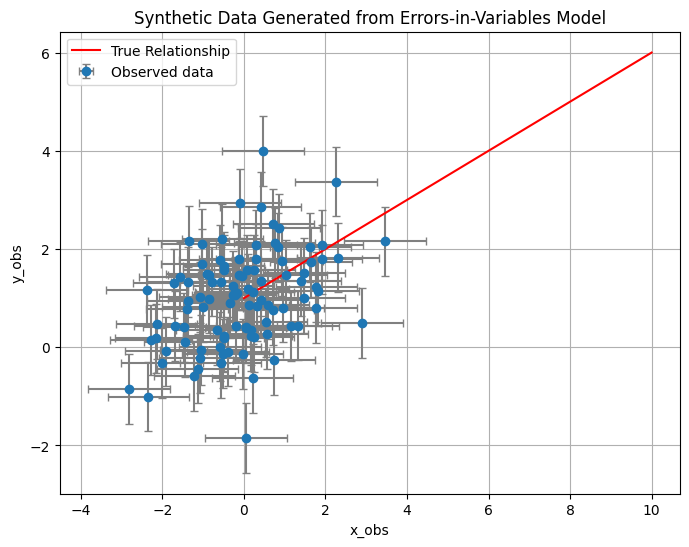

In [102]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of data points
N       = 100
# Chosen parameter values
sigma_int = 0.5
theta_0 = 1.0
theta_1 = 0.5
x0      = 0
Rx      = 1       # So Rx^2 = 1.0
sigma_x = 1
sigma_y = 0.5

# Hyperparameters for priors (not used in data generation)
mu_x0 = 1.0
sigma_x0_squared = 1.0
alpha_R = 0.1
beta_R = 1
alpha_sigma = 0.1
beta_sigma = 1


# Step 2: Generate latent x_i values
x_true = np.random.normal(loc=x0, scale=Rx, size=N)

# Step 3: Generate observed x_i^{obs} values
x_obs = np.random.normal(loc=x_true, scale=sigma_x, size=N)

# Step 4: Generate observed y_i^{obs} values
mu_y = theta_0 + theta_1 * x_true
y_obs = np.random.normal(loc=mu_y, scale=np.sqrt(sigma_y**2+sigma_int**2), size=N)

# Plot the generated data
plt.figure(figsize=(8, 6))
plt.errorbar(x_obs, y_obs, xerr=sigma_x, yerr=np.sqrt(sigma_y**2+sigma_int**2), fmt='o', ecolor='gray', capsize=3, label='Observed data')
plt.xlabel('x_obs')
plt.ylabel('y_obs')
plt.title('Synthetic Data Generated from Errors-in-Variables Model')
plt.grid(True)

def true_relationship(x, theta_0, theta_1):
    return theta_0 + theta_1 * x
x_true  = np.linspace(0, 10, 100)
y_true = true_relationship(x_true, theta_0, theta_1)
plt.plot(x_true, y_true, label='True Relationship', color='red')
plt.legend()
plt.show()


### Gibbs Sampler
Overview
Objective:
- Implement a Gibbs sampler to sample from the joint posterior distribution of the parameters $\boldsymbol{\theta}=\left(\theta_0, \theta_1\right)$, the population parameters $x_0$ and $R_x$, and the latent variables $x_i$ for $i=$ $1, \ldots, N$.

Steps:
1. Sample the latent variables $x_i$ :
- Derive the conditional distribution $p\left(x_i \mid\right.$ rest $)$, which is Gaussian.
- Sample $x_i$ from this conditional distribution.
2. Sample the regression coefficients $\theta$ :
- Derive the conditional distribution $p(\theta \mid$ rest $)$, which is a bivariate Gaussian.
- Sample $\theta_0$ and $\theta_1$ jointly from this distribution.
3. Sample $x_0$ and $R_x$ :
- Derive their conditional distributions based on the conjugate priors.
- Sample $x_0$ and $R_x^2$ accordingly.
4. Iterate:
- Repeat steps 1-3 for a number of iterations to allow the chain to converge to the target distribution.


Implementing the Gibbs Sampler
1. Sampling the Latent Variables $x_i$

Conditional Distribution:
The conditional distribution of $x_i$ given the rest is:

$$
x_i \mid \text { rest } \sim \mathcal{N}\left(\mu_{x_i}, \sigma_{x_i}^2\right)
$$


Where:

$$
\begin{aligned}
\sigma_{x_i}^2 & =\left(\frac{\theta_1^2}{\sigma_y^2}+\frac{1}{\sigma_x^2}+\frac{1}{R_x^2}\right)^{-1} \\
\mu_{x_i} & =\sigma_{x_i}^2\left(\frac{\theta_1\left(y_i^{\mathrm{obs}}-\theta_0\right)}{\sigma_y^2}+\frac{x_i^{\mathrm{obs}}}{\sigma_x^2}+\frac{x_0}{R_x^2}\right)
\end{aligned}
$$
2. Sampling the Latent Variables $y_i$
$$
y_i \mid \text { rest } \sim \mathcal{N}\left(\theta_{1} + \theta_{2}x_i, \sigma_{\text{int}}^2\right)
$$


3. Sampling the Regression Coefficients $\boldsymbol{\theta}$

Conditional Distribution:
The conditional distribution of $\theta=\left(\theta_0, \theta_1\right)$ given the rest is a bivariate Gaussian:

$$
\theta \mid \text { rest } \sim \mathcal{N}\left(\boldsymbol{\mu}_\theta, \boldsymbol{\Sigma}_\theta\right)
$$


Where:

$$
\begin{aligned}
\boldsymbol{\Sigma}_\theta & =\left(\frac{1}{\sigma_y^2} \mathbf{X}^{\top} \mathbf{X}+\boldsymbol{\Sigma}_0^{-1}\right)^{-1} \\
\boldsymbol{\mu}_\theta & =\boldsymbol{\Sigma}_\theta\left(\frac{1}{\sigma_y^2} \mathbf{X}^{\top} \mathbf{y}^{\mathrm{obs}}+\boldsymbol{\Sigma}_0^{-1} \boldsymbol{\mu}_0\right)
\end{aligned}
$$

- $\mathbf{X}$ is the design matrix with a column of ones and the latent $x_i$ :

$$
\mathbf{X}=\left[\begin{array}{cc}
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_N
\end{array}\right]
$$

- $\boldsymbol{\Sigma}_0$ is the prior covariance matrix for $\boldsymbol{\theta}$.
- $\boldsymbol{\mu}_0$ is the prior mean vector for $\boldsymbol{\theta}$.
4. Sampling $x_0$ and $R_x^2$

Since we have conjugate priors for $x_0$ and $R_x^2$, their conditional distributions can be derived.
Sampling $x_0$ :
The conditional distribution of $x_0$ given $x_i$ and $R_x^2$ is Gaussian:

$$
x_0 \mid \text { rest } \sim \mathcal{N}\left(\mu_{x_0}, \sigma_{x_0}^2\right)
$$


Where:

$$
\begin{aligned}
& \sigma_{x_0}^2=\left(\frac{N}{R_x^2}+\frac{1}{\sigma_{x_0}^2}\right)^{-1} \\
& \mu_{x_0}=\sigma_{x_0}^2\left(\frac{\sum_{i=1}^N x_i}{R_x^2}+\frac{\mu_{x_0}}{\sigma_{x_0}^2}\right)
\end{aligned}
$$


Sampling $R_x^2$ :
The conditional distribution of $R_x^2$ given $x_i$ and $x_0$ is Inverse-Gamma:

$$
R_x^2 \mid \text { rest } \sim \text { Inv-Gamma }\left(\alpha_R+\frac{N}{2}, \beta_R+\frac{1}{2} \sum_{i=1}^N\left(x_i-x_0\right)^2\right)
$$

5. Sampling $\sigma_{\text{int}}$
The conditional distribution of $\sigma_{\text{int}}$ is an Inverse-Gamma
$$
\sigma_{\text{int}}^2 \mid \text { rest } \sim \text { Inv-Gamma }\left(\alpha_\sigma+\frac{N}{2}, \beta_\sigma+\frac{1}{2} \sum_{i=1}^N\left(y_i-\theta_1 - \theta_2x_2 \right)^2\right)
$$

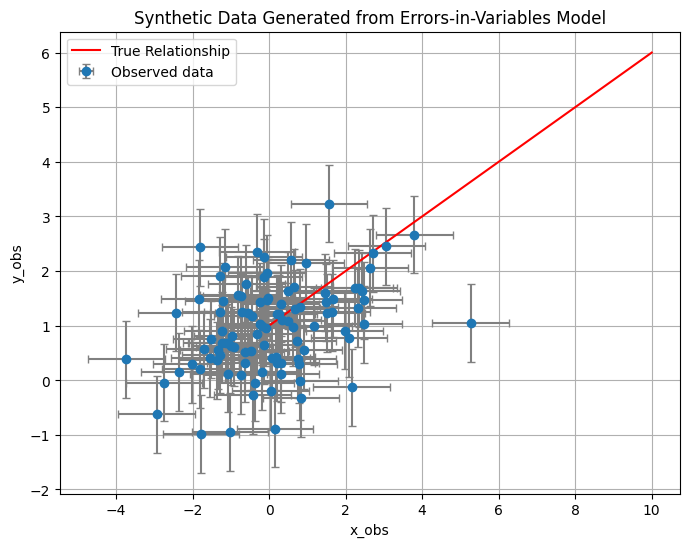

0.40532059044392
Iteration 0 completed.
Iteration 500 completed.
Iteration 1000 completed.
Iteration 1500 completed.
Iteration 2000 completed.
Iteration 2500 completed.
Iteration 3000 completed.
Iteration 3500 completed.
Iteration 4000 completed.
Iteration 4500 completed.
Iteration 5000 completed.
Iteration 5500 completed.
Iteration 6000 completed.
Iteration 6500 completed.
Iteration 7000 completed.
Iteration 7500 completed.
Iteration 8000 completed.
Iteration 8500 completed.
Iteration 9000 completed.
Iteration 9500 completed.
Iteration 10000 completed.
Iteration 10500 completed.
Iteration 11000 completed.
Iteration 11500 completed.
Iteration 12000 completed.
Iteration 12500 completed.
Iteration 13000 completed.
Iteration 13500 completed.
Iteration 14000 completed.
Iteration 14500 completed.
Iteration 15000 completed.
Iteration 15500 completed.
Iteration 16000 completed.
Iteration 16500 completed.
Iteration 17000 completed.
Iteration 17500 completed.
Iteration 18000 completed.
Iteratio

In [103]:
# Set random seed for reproducibility
# np.random.seed(42)

# # Number of data points
# N = 100


# True parameter values (used in data generation)
theta_0_true = theta_0
theta_1_true = theta_1
x0_true = x0
Rx_true = Rx       # So Rx^2 = 1.0
sigma_x_true = sigma_x
sigma_y_true = sigma_y
sigma_int_true = sigma_int

# Hyperparameters for priors on theta
mu_theta = 0.0
sigma_theta_squared = 4.0 ** 2  # Large variance for non-informative prior

# Generate synthetic data
# Step 1: Generate latent x_i values
x_true = np.random.normal(loc=x0_true, scale=Rx_true, size=N)

# Step 2: Generate observed x_i^{obs} values
x_obs = np.random.normal(loc=x_true, scale=sigma_x_true, size=N)

# Step 3: Generate observed y_i^{obs} values
mu_y = theta_0_true + theta_1_true * x_true
y_obs = np.random.normal(loc=mu_y, scale=(np.sqrt(sigma_y_true**2+sigma_int_true**2)), size=N)


# Plot the generated data
plt.figure(figsize=(8, 6))
plt.errorbar(x_obs, y_obs, xerr=sigma_x_true, yerr=np.sqrt(sigma_y_true**2+sigma_int_true**2), fmt='o', ecolor='gray', capsize=3, label='Observed data')
plt.xlabel('x_obs')
plt.ylabel('y_obs')
plt.title('Synthetic Data Generated from Errors-in-Variables Model')
plt.grid(True)

def true_relationship(x, theta_0, theta_1):
    return theta_0 + theta_1 * x
x_true  = np.linspace(0, 10, 100)
y_true = true_relationship(x_true, theta_0, theta_1)
plt.plot(x_true, y_true, label='True Relationship', color='red')
plt.legend()
plt.show()


# Number of iterations for Gibbs sampler
num_iterations = 20000

# Initialize arrays to store samples
theta_0_samples = np.zeros(num_iterations)
theta_1_samples = np.zeros(num_iterations)
x0_samples = np.zeros(num_iterations)
Rx2_samples = np.zeros(num_iterations)
x_i_samples = np.zeros((num_iterations, N))
sigma_int_samples = np.zeros(num_iterations)

# Initial values
theta_0 = 0.0
theta_1 = 0.0
x0 = np.mean(x_obs)
Rx2 = np.var(x_obs)
x_i = x_obs.copy()  # Initialize x_i with observed x_obs
# sigma_int_y = np.std(y_obs)
sigma_int_x2 = np.std(y_obs)/2
print(sigma_int_x2)

# Prior covariance matrix for theta
Sigma_0_inv = np.linalg.inv(np.diag([sigma_theta_squared, sigma_theta_squared]))
mu_0 = np.array([mu_theta, mu_theta])

# Start Gibbs sampling
for t in range(num_iterations):
    # Step 1: Sample x_i
    for i in range(N):
        # Compute posterior variance and mean
        sigma_xi_squared = 1 / (theta_1**2 / (sigma_int_x2 + sigma_y_true**2) + 1 / sigma_x_true**2 + 1 / Rx2)
        mu_xi = sigma_xi_squared * (
            theta_1 * (y_obs[i] - theta_0) / (sigma_int_x2+sigma_y_true**2) +
            x_obs[i] / sigma_x_true**2 +
            x0 / Rx2
        )
        # Sample x_i
        x_i[i] = np.random.normal(mu_xi, np.sqrt(sigma_xi_squared))
    # Step 2: Sample y_i
    y_i = np.random.normal(theta_0 + theta_1 * x_i, np.sqrt(sigma_int_x2))

    # Step 3: Sample theta_0 and theta_1 jointly
    # Build design matrix X
    X = np.vstack((np.ones(N), x_i)).T  # Shape (N, 2)
    y = y_i # Shape (N,)
    # Compute posterior covariance and mean
    Sigma_theta_inv = (X.T @ X) / (sigma_int_x2) + Sigma_0_inv
    Sigma_theta = np.linalg.inv(Sigma_theta_inv)
    mu_theta_post = Sigma_theta @ (X.T @ y / (sigma_int_x2) + Sigma_0_inv @ mu_0)
    # Sample theta
    theta_sample = np.random.multivariate_normal(mu_theta_post, Sigma_theta)
    theta_0, theta_1 = theta_sample


    # Step 4: Sample x0
    sigma_x0_squared_post = 1 / (N / Rx2 + 1 / sigma_x0_squared)
    mu_x0_post = sigma_x0_squared_post * (np.sum(x_i) / Rx2 + mu_x0 / sigma_x0_squared)
    x0 = np.random.normal(mu_x0_post, np.sqrt(sigma_x0_squared_post))

    # Step 5: Sample Rx^2
    alpha_R_post = alpha_R + N / 2
    beta_R_post = beta_R + 0.5 * np.sum((x_i - x0)**2)
    Rx2 = invgamma.rvs(a=alpha_R_post, scale=beta_R_post)

    # Step 6: Sample sigma_int
    alpha_sigma_int_post = alpha_sigma + N / 2
    beta_sigma_int_post = beta_sigma + 0.5 * np.sum((y_i - theta_0 - theta_1 * x_i)**2)
    sigma_int_x2 = invgamma.rvs(a=alpha_sigma_int_post, scale=beta_sigma_int_post)

    # Store samples
    theta_0_samples[t] = theta_0
    theta_1_samples[t] = theta_1
    x0_samples[t] = x0
    Rx2_samples[t] = Rx2
    sigma_int_samples[t] = sigma_int_x2
    x_i_samples[t, :] = x_i

    if t % 500 == 0:
        print(f"Iteration {t} completed.")

# Convert Rx^2 samples to Rx samples
Rx_samples = np.sqrt(Rx2_samples)
# Convert sigma_int^2 samples to sigma_int samples
sigma_int_samples = np.sqrt(sigma_int_samples)

# Discard burn-in samples
burn_in = 1000
theta_0_samples = theta_0_samples[burn_in:]
theta_1_samples = theta_1_samples[burn_in:]
x0_samples = x0_samples[burn_in:]
Rx_samples = Rx_samples[burn_in:]
sigma_int_samples = sigma_int_samples[burn_in:]
x_i_samples = x_i_samples[burn_in:, :]


In [55]:
x_i_samples.shape


(19000, 100)

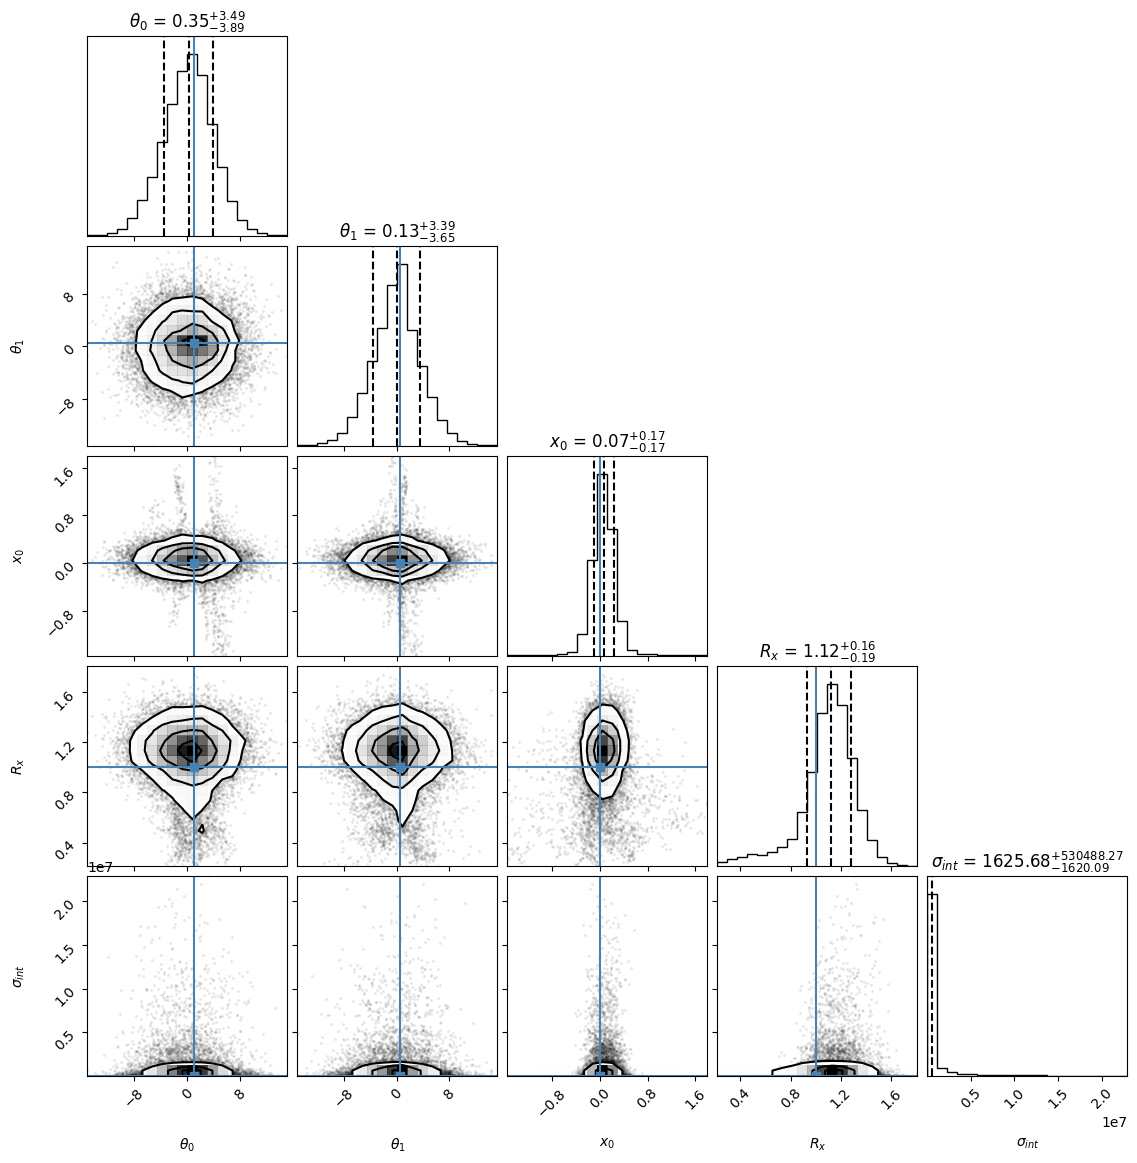

23
67
43


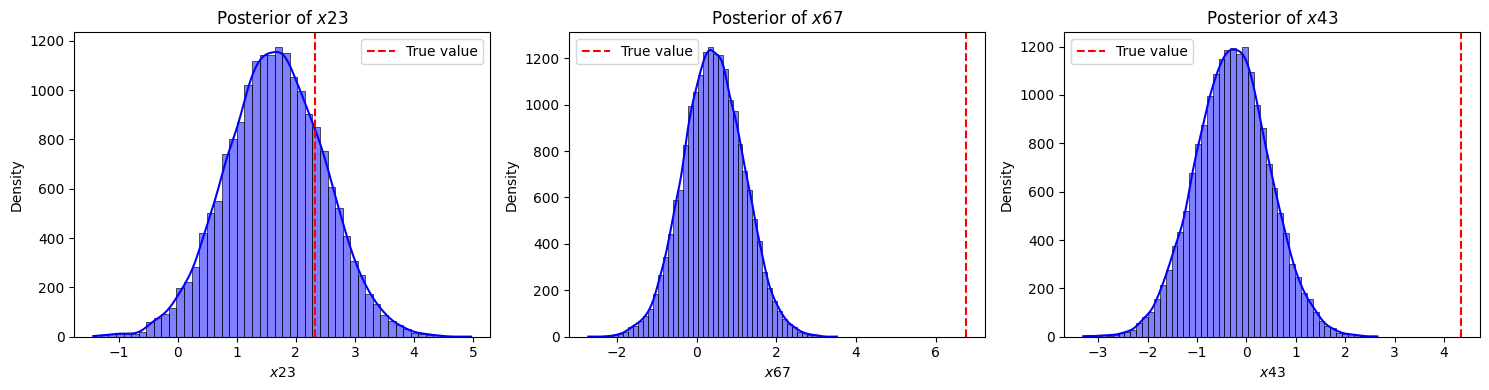

In [104]:
# Plotting with corner
plot_samples = np.vstack([theta_0_samples, theta_1_samples, x0_samples, Rx_samples,sigma_int_samples]).T
labels = [r"$\theta_0$", r"$\theta_1$", r"$x_0$", r"$R_x$", r"$\sigma_{int}$"]
truths = [theta_0_true, theta_1_true, x0_true, Rx_true, sigma_int_true]

figure = corner.corner(
    plot_samples,
    labels=labels,
    truths=truths,
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".2f",
    title_kwargs={"fontsize": 12}
)

plt.show()

# Visualize marginal posteriors for selected x_i
indices = [23, 67, 43]
x_i_samples_selected = x_i_samples[:, indices]
x_i_true_selected = x_true[indices]

num_selected = len(indices)
fig, axes = plt.subplots(1, num_selected, figsize=(5 * num_selected, 4))

for i, idx in enumerate(indices):
    print(idx)
    ax = axes[i] if num_selected > 1 else axes
    sns.histplot(x_i_samples_selected[:, i], bins=50, kde=True, ax=ax, color='blue')
    ax.set_xlabel(f"$x {idx}$")
    ax.set_ylabel("Density")
    ax.set_title(f"Posterior of $x {idx}$")
    ax.axvline(x_i_true_selected[i], color='red', linestyle='--', label='True value')
    ax.legend()

plt.tight_layout()
plt.show()

## Model with intrinsic dispersion (Correct's problem version)

$$
y_i \mid y_i^{\mathrm{obs}},\,\theta_0,\theta_1,\,x_i,\,\sigma_y,\,\sigma_{\text{int}}
\sim \mathcal{N}\Bigl(\mu_{y_i},\,\sigma_{y_i}^2\Bigr),
$$
with
$$
\mu_{y_i} = \left(\frac{1}{\sigma_y^2} + \frac{1}{\sigma_{\text{int}}^2}\right)^{-1} \left(\frac{y_i^{\mathrm{obs}}}{\sigma_y^2} + \frac{\theta_0+\theta_1\,x_i}{\sigma_{\text{int}}^2}\right)
$$
and
$$
\sigma_{y_i}^2 = \left(\frac{1}{\sigma_y^2} + \frac{1}{\sigma_{\text{int}}^2}\right)^{-1}.
$$


In [88]:
@dataclass(frozen=True)
class Parameters:
    N: int
    # Chosen parameter values
    sigma_int: float
    theta_0: float 
    theta_1: float
    x_0: float 
    Rx: float # So Rx^2 = 1.0
    sigma_x: float 
    sigma_y: float

    # Hyperparameters for priors (not used in data generation)
    mu_x0: float
    sigma_x0: float
    alpha_R: float
    beta_R: float
    alpha_sigma: float
    beta_sigma: float
    
def generate_latents(params: Parameters, n: int = None) -> tuple[np.ndarray]:
    if n is None:
        n = params
    x_true = np.random.normal(loc=params.x_0, scale=params.Rx, size=n)
    mu_y = params.theta_0 + params.theta_1 * x_true
    y_true = np.random.normal(loc=mu_y, scale=np.sqrt(params.sigma_int), size=n)
    return x_true, mu_y, y_true

def generate_obs(x_true: np.ndarray, y_true: np.ndarray, params: Parameters, n: int = None) -> tuple[np.ndarray]:
    if n is None:
        n = params.N
    x_obs = np.random.normal(loc=x_true, scale=np.sqrt(params.sigma_x), size=n)
    y_obs = np.random.normal(loc=y_true, scale=np.sqrt(params.sigma_y), size=n)
    return x_obs, y_obs

def true_relationship(x, theta_0, theta_1):
    return theta_0 + theta_1 * x

def plot_data(x_obs: np.ndarray, y_obs: np.ndarray, x_true: np.ndarray, y_true: np.ndarray,params) -> None:
    plt.figure(figsize=(8, 6))
    plt.errorbar(x_obs, y_obs, xerr=params.sigma_x, yerr=np.sqrt(params.sigma_y+params.sigma_int), fmt='o', ecolor='gray', capsize=3, label='Observed data')
    plt.xlabel('x_obs')
    plt.ylabel('y_obs')
    plt.title('Synthetic Data Generated from Errors-in-Variables Model')
    plt.grid(True)
    plt.plot(x_true, y_true, label='True Relationship', color='red')
    plt.legend()
    plt.show()

def sample_x_i(vars, params):
    x_i = vars["x_i"]
    for i in range(N):
        sigma_xi_squared = 1 / (theta_1**2 / (vars["sigma_int"] + params.sigma_y) + 1 / params.sigma_x + 1 / vars["Rx2"])
        mu_xi = sigma_xi_squared * (
            vars["theta_1"] * (vars["y_i"][i] - vars["theta_0"]) / (vars["sigma_int"]+params.sigma_y) +
            x_i[i] / params.sigma_x**2 +
            vars["x_0"] / vars["Rx2"]
        )
        x_i[i] = np.random.normal(mu_xi, np.sqrt(sigma_xi_squared))
    return x_i
def sample_y_i(vars, params):
    mu_yi = (vars["y_i"]/vars["sigma_int"] + (vars["theta_0"] + vars["theta_1"]*vars["x_i"])/params.sigma_y)/(1/vars["sigma_int"] + 1/params.sigma_y)
    sigma_yi = np.sqrt(1/(1/vars["sigma_int"] + 1/params.sigma_y))
    y_i = np.random.normal(mu_yi, sigma_yi)
    # mu_yi = (vars["sigma_int"]*vars["y_i"] + vars["sigma_int"]*(vars["theta_0"] + vars["theta_1"]*vars["x_i"]))/(vars["sigma_int"] + params.sigma_y**2)
    # sigma_yi = np.sqrt(vars["sigma_int"]*params.sigma_y**2/(vars["sigma_int"] + params.sigma_y**2))
    # y_i = np.random.normal(mu_yi, sigma_yi)
    # y_i = np.random.normal(vars["theta_0"] + vars["theta_1"] * vars["x_i"], np.sqrt(vars["sigma_int"]))
    return y_i

def sample_theta(vars, params):
    X = np.vstack((np.ones(N), vars["x_i"])).T
    y = vars["y_i"]
    sigma_theta_inv = (X.T @ X) / (vars["sigma_int"]) + vars["sigma_0_inv"]
    sigma_theta = np.linalg.inv(sigma_theta_inv)
    mu_theta_post = sigma_theta @ (X.T @ y / (vars["sigma_int"]) + vars["sigma_0_inv"] @ vars["mu_0"])
    theta_sample = np.random.multivariate_normal(mu_theta_post, sigma_theta)
    return theta_sample

def sample_x0(vars, params):
    sigma_x0_squared_post = 1 / (N / vars["Rx2"] + 1 / params.sigma_x0)
    mu_x0_post = sigma_x0_squared_post * (np.sum(vars["x_i"]) / vars["Rx2"] + params.mu_x0 / params.sigma_x0)
    x0 = np.random.normal(mu_x0_post, np.sqrt(sigma_x0_squared_post))
    return x0

def sample_Rx2(vars, params):
    alpha_R_post = params.alpha_R + N / 2
    beta_R_post = params.beta_R + 0.5 * np.sum((vars["x_i"] - vars["x_0"])**2)
    Rx2 = invgamma.rvs(a=alpha_R_post, scale=beta_R_post)
    return Rx2

def sample_sigma_int(vars, params):
    alpha_sigma_int_post = params.alpha_sigma + N / 2
    beta_sigma_int_post = params.beta_sigma + 0.5 * np.sum((vars["y_i"] - vars["theta_0"] - vars["theta_1"] * vars["x_i"])**2)
    sigma_int_x2 = invgamma.rvs(a=alpha_sigma_int_post, scale=beta_sigma_int_post)
    return sigma_int_x2

def init_arrays(num_iterations):
    theta_0_samples = np.zeros(num_iterations)
    theta_1_samples = np.zeros(num_iterations)
    x0_samples = np.zeros(num_iterations)
    Rx2_samples = np.zeros(num_iterations)
    x_i_samples = np.zeros((num_iterations, N))
    sigma_int_samples = np.zeros(num_iterations)
    return {
        "theta_0": theta_0_samples,
        "theta_1": theta_1_samples, 
        "x_0": x0_samples,
        "Rx2": Rx2_samples,
        "x_i": x_i_samples,
        "sigma_int": sigma_int_samples}
def corner_plot(samples, params):
    plot_samples = np.vstack([samples["theta_0"], samples["theta_1"], samples["x_0"], samples["Rx2"], samples["sigma_int"]]).T
    labels = [r"$\theta_0$", r"$\theta_1$", r"$x_0$", r"$R_x$", r"$\sigma_{int}$"]
    truths = [params.theta_0, params.theta_1, params.x_0, params.Rx, params.sigma_int]

    figure = corner.corner(
        plot_samples,
        labels=labels,
        truths=truths,
        show_titles=True,
        quantiles=[0.16, 0.5, 0.84],
        title_fmt=".2f",
        title_kwargs={"fontsize": 12}
    )

    plt.show()

def plot_marginal(samples, x_true):
    indices = [23, 67, 43]
    x_i_samples_selected = samples["x_i"][:, indices]
    x_i_true_selected = x_true[indices]

    num_selected = len(indices)
    fig, axes = plt.subplots(1, num_selected, figsize=(5 * num_selected, 4))

    for i, idx in enumerate(indices):
        ax = axes[i] if num_selected > 1 else axes
        sns.histplot(x_i_samples_selected[:, i], bins=50, kde=True, ax=ax, color='blue')
        ax.set_xlabel(f"$x {idx}$")
        ax.set_ylabel("Density")
        ax.set_title(f"Posterior of $x {idx}$")
        ax.axvline(x_i_true_selected[i], color='red', linestyle='--', label='True value')
        ax.legend()

    plt.tight_layout()
    plt.show()


In [89]:
params = Parameters( 
        N = 100,
        sigma_int = 0.25,
        theta_0 = 1.0,
        theta_1 = 0.5,
        x_0 = 5.0,
        Rx = 1,    # So Rx^2 = 1.0
        sigma_x = 1,
        sigma_y = 0.25,
        # Hyperparameters for priors (not used in data generation)
        mu_x0 = 1.0,
        sigma_x0 = 1.0,
        alpha_R = 0.1,
        beta_R = 1,
        alpha_sigma = 0.1,
        beta_sigma = 1,
        )

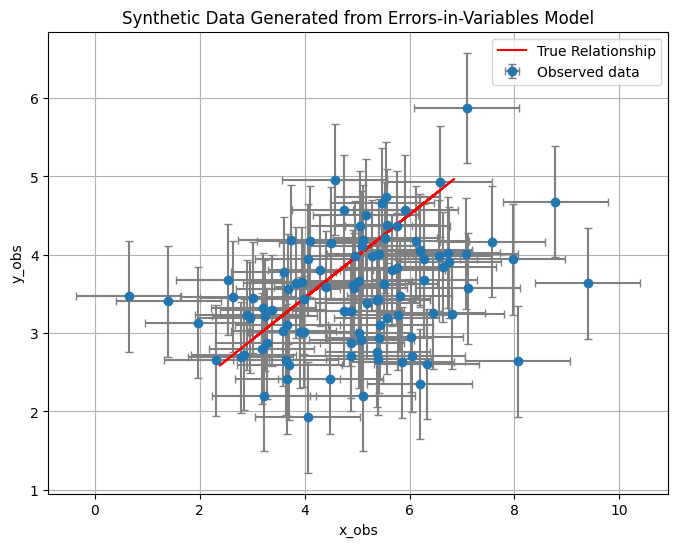

In [90]:
# Set random seed for reproducibility
np.random.seed(42)

x_true, mu_y, y_true = generate_latents(params,100)
x_obs, y_obs = generate_obs(x_true, y_true, params,100)

# Plot the generated data
y_true_wo_int_dip = true_relationship(x_true, theta_0, theta_1)

plot_data(
    x_obs=x_obs,
    y_obs=y_obs,
    x_true=x_true,
    y_true=y_true_wo_int_dip,
    params=params
    )

In [91]:
# Number of iterations for Gibbs sampler
num_iterations = 20000

samples = init_arrays(num_iterations)
# Initial values
vars = {
    "theta_0": 0.0,
    "theta_1": 0.0,
    "x_0": np.mean(x_obs),
    "Rx2": np.var(x_obs),
    "x_i": x_obs.copy(),
    "y_i": y_obs.copy(),
    "sigma_int": np.std(y_obs)/2,
    "mu_0": np.array([mu_theta, mu_theta]),
    "mu_theta": 0.0,
    "sigma_theta_squared": 4.0 ** 2
}
vars["sigma_0_inv"]= np.linalg.inv(np.diag([vars["sigma_theta_squared"], vars["sigma_theta_squared"]]))

# Start Gibbs sampling
for t in range(num_iterations):
    # Step 1: Sample x_i
    vars["x_i"] = sample_x_i(vars, params)
    # Step 2: Sample y_i
    vars["y_i"] = sample_y_i(vars, params)
    # Step 3: Sample theta_0 and theta_1 jointly
    vars["theta_0"], vars["theta_1"] = sample_theta(vars, params)
    # Step 4: Sample x0
    vars["x_0"] = sample_x0(vars, params)
    # Step 5: Sample Rx^2
    vars["Rx2"] = sample_Rx2(vars, params)
    # Step 6: Sample sigma_int
    vars["sigma_int"] = sample_sigma_int(vars, params)
    
    for key in samples.keys():
        samples[key][t] = vars[key]
    
    if t % 500 == 0:
        print(f"Iteration {t} completed.")

# Convert Rx^2 samples to Rx samples
Rx_samples = np.sqrt(Rx2_samples)
# Convert sigma_int^2 samples to sigma_int samples
sigma_int_samples = np.sqrt(sigma_int_samples)

# Discard burn-in samples
burn_in = 1000
for key in samples:
    samples[key] = samples[key][burn_in:]


Iteration 0 completed.
Iteration 500 completed.
Iteration 1000 completed.
Iteration 1500 completed.
Iteration 2000 completed.
Iteration 2500 completed.
Iteration 3000 completed.
Iteration 3500 completed.
Iteration 4000 completed.
Iteration 4500 completed.
Iteration 5000 completed.
Iteration 5500 completed.
Iteration 6000 completed.
Iteration 6500 completed.
Iteration 7000 completed.
Iteration 7500 completed.
Iteration 8000 completed.
Iteration 8500 completed.
Iteration 9000 completed.
Iteration 9500 completed.
Iteration 10000 completed.
Iteration 10500 completed.
Iteration 11000 completed.
Iteration 11500 completed.
Iteration 12000 completed.
Iteration 12500 completed.
Iteration 13000 completed.
Iteration 13500 completed.
Iteration 14000 completed.
Iteration 14500 completed.
Iteration 15000 completed.
Iteration 15500 completed.
Iteration 16000 completed.
Iteration 16500 completed.
Iteration 17000 completed.
Iteration 17500 completed.
Iteration 18000 completed.
Iteration 18500 completed

In [52]:
samples.keys()

dict_keys(['theta_0', 'theta_1', 'x_0', 'Rx2', 'x_i', 'sigma_int'])

In [68]:
samples["sigma_int"].min()

np.float64(0.3088698283371822)

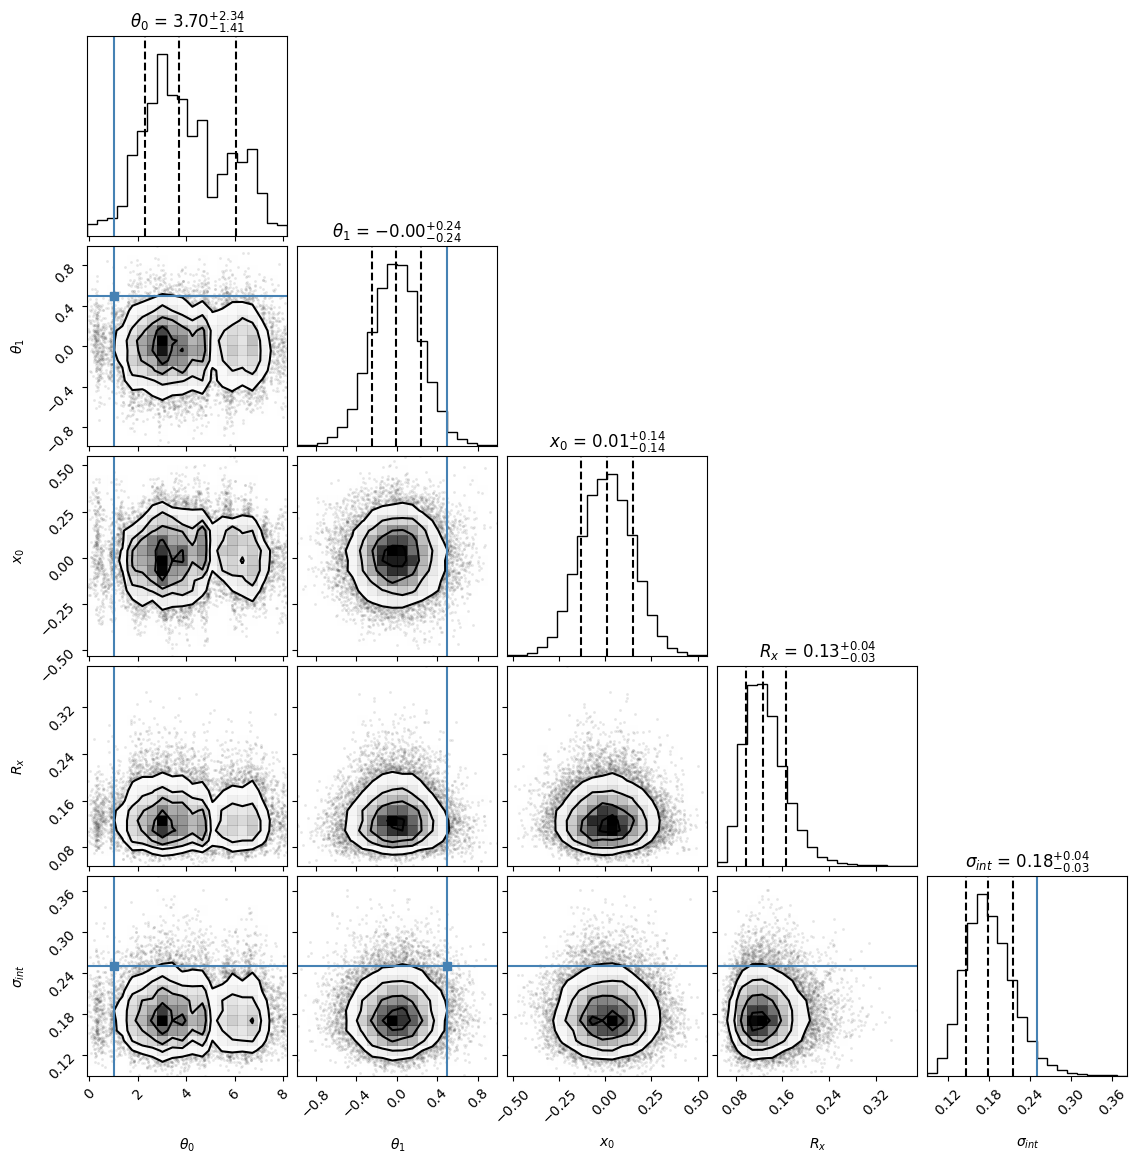

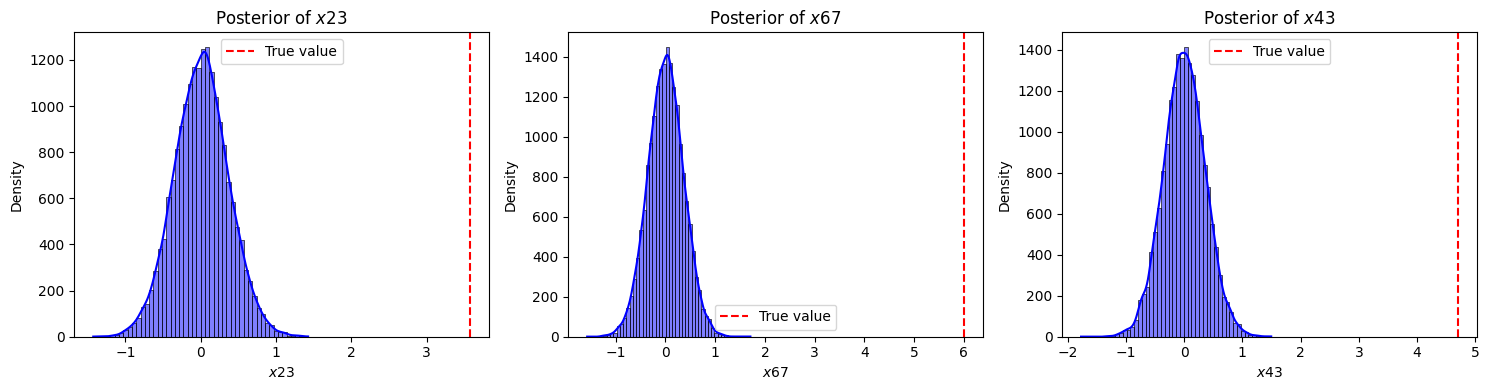

In [92]:
corner_plot(samples, params)
plot_marginal(samples, x_true)
# plot_samples = np.vstack([samples["theta_0"], samples["theta_1"], samples["x_0"], samples["Rx2"], samples["sigma_int"]]).T
# labels = [r"$\theta_0$", r"$\theta_1$", r"$x_0$", r"$R_x$", r"$\sigma_{int}$"]
# truths = [params.theta_0, params.theta_1, params.x0, params.Rx, params.sigma_int]

# figure = corner.corner(
#     plot_samples,
#     labels=labels,
#     truths=truths,
#     show_titles=True,
#     quantiles=[0.16, 0.5, 0.84],
#     title_fmt=".2f",
#     title_kwargs={"fontsize": 12}
# )

# plt.show()

## Model with intrinsic dispersion and selection function

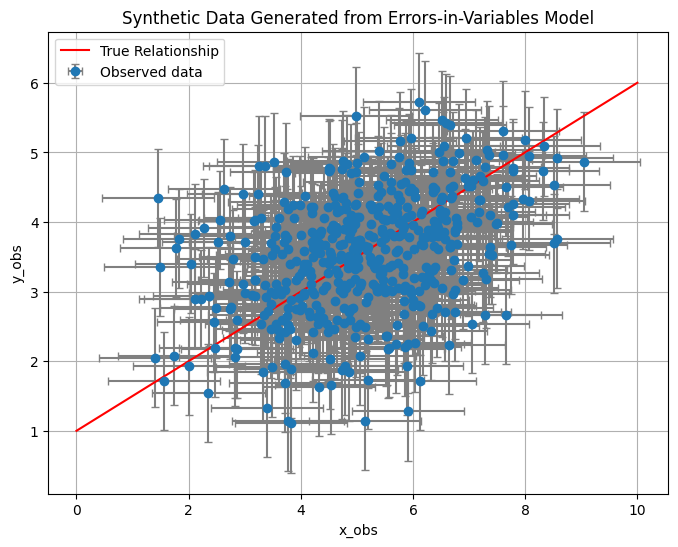

In [99]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of data points
N       = 500
# Chosen parameter values
sigma_int = 0.5
theta_0 = 1.0
theta_1 = 0.5
x0      = 5.0
Rx      = 1       # So Rx^2 = 1.0
sigma_x = 1
sigma_y = 0.5
gamma = Rx*0.5

# Hyperparameters for priors (not used in data generation)
mu_x0 = 1.0
sigma_x0_squared = 1.0
alpha_R = 0.1
beta_R = 1
alpha_sigma = 0.1
beta_sigma = 1


# Step 2: Generate latent x_i values
x_true = np.random.normal(loc=x0, scale=Rx, size=N)
mu_y = theta_0 + theta_1 * x_true
y_true = np.random.normal(loc=mu_y, scale=sigma_int, size=N)





# Plot the generated data
plt.figure(figsize=(8, 6))
plt.errorbar(x_obs, y_obs, xerr=sigma_x, yerr=np.sqrt(sigma_y**2+sigma_int**2), fmt='o', ecolor='gray', capsize=3, label='Observed data')
plt.xlabel('x_obs')
plt.ylabel('y_obs')
plt.title('Synthetic Data Generated from Errors-in-Variables Model')
plt.grid(True)

def true_relationship(x, theta_0, theta_1):
    return theta_0 + theta_1 * x
x_true  = np.linspace(0, 10, 100)
y_true = true_relationship(x_true, theta_0, theta_1)
plt.plot(x_true, y_true, label='True Relationship', color='red')
plt.legend()
plt.show()


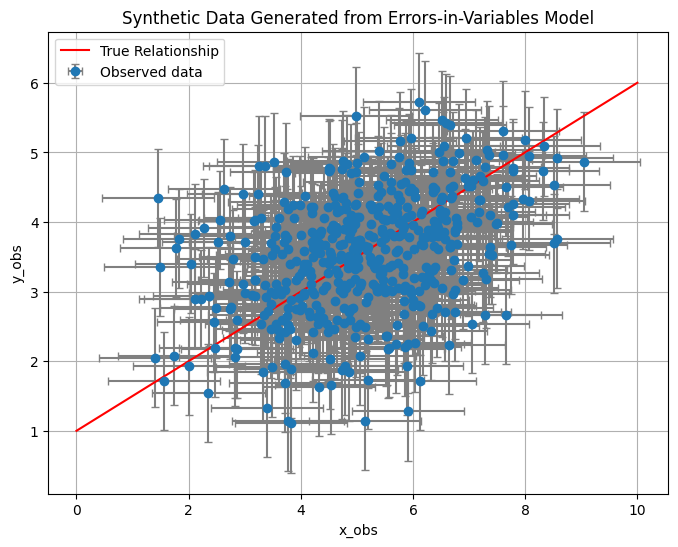

0.42175872644409224
Iteration 0 completed.
Iteration 500 completed.
Iteration 1000 completed.
Iteration 1500 completed.
Iteration 2000 completed.
Iteration 2500 completed.
Iteration 3000 completed.
Iteration 3500 completed.
Iteration 4000 completed.
Iteration 4500 completed.
Iteration 5000 completed.
Iteration 5500 completed.
Iteration 6000 completed.
Iteration 6500 completed.
Iteration 7000 completed.
Iteration 7500 completed.
Iteration 8000 completed.
Iteration 8500 completed.
Iteration 9000 completed.
Iteration 9500 completed.
Iteration 10000 completed.
Iteration 10500 completed.
Iteration 11000 completed.
Iteration 11500 completed.
Iteration 12000 completed.
Iteration 12500 completed.
Iteration 13000 completed.
Iteration 13500 completed.
Iteration 14000 completed.
Iteration 14500 completed.
Iteration 15000 completed.
Iteration 15500 completed.
Iteration 16000 completed.
Iteration 16500 completed.
Iteration 17000 completed.
Iteration 17500 completed.
Iteration 18000 completed.
Itera

In [100]:
# Set random seed for reproducibility
# np.random.seed(42)

# # Number of data points
# N = 100


# True parameter values (used in data generation)
theta_0_true = theta_0
theta_1_true = theta_1
x0_true = x0
Rx_true = Rx       # So Rx^2 = 1.0
sigma_x_true = sigma_x
sigma_y_true = sigma_y
sigma_int_true = sigma_int

# Hyperparameters for priors on theta
mu_theta = 0.0
sigma_theta_squared = 4.0 ** 2  # Large variance for non-informative prior

# Generate synthetic data
# Step 1: Generate latent x_i values
x_true = np.random.normal(loc=x0_true, scale=Rx_true, size=N)

# Step 2: Generate observed x_i^{obs} values
x_obs = np.random.normal(loc=x_true, scale=sigma_x_true, size=N)

# Step 3: Generate observed y_i^{obs} values
mu_y = theta_0_true + theta_1_true * x_true

y_true = np.random.normal(loc=mu_y, scale=sigma_int_true, size=N)
y_obs = np.random.normal(loc=y_true, scale=sigma_y, size=N)


# Plot the generated data
plt.figure(figsize=(8, 6))
plt.errorbar(x_obs, y_obs, xerr=sigma_x_true, yerr=np.sqrt(sigma_y_true**2+sigma_int_true**2), fmt='o', ecolor='gray', capsize=3, label='Observed data')
plt.xlabel('x_obs')
plt.ylabel('y_obs')
plt.title('Synthetic Data Generated from Errors-in-Variables Model')
plt.grid(True)

def true_relationship(x, theta_0, theta_1):
    return theta_0 + theta_1 * x
x_true  = np.linspace(0, 10, 100)
y_true = true_relationship(x_true, theta_0, theta_1)
plt.plot(x_true, y_true, label='True Relationship', color='red')
plt.legend()
plt.show()

# Number of iterations for Gibbs sampler
num_iterations = 20000

# Initialize arrays to store samples
theta_0_samples = np.zeros(num_iterations)
theta_1_samples = np.zeros(num_iterations)
x0_samples = np.zeros(num_iterations)
Rx2_samples = np.zeros(num_iterations)
x_i_samples = np.zeros((num_iterations, N))
sigma_int_samples = np.zeros(num_iterations)

# Initial values
theta_0 = 0.0
theta_1 = 0.0
x0 = np.mean(x_obs)
Rx2 = np.var(x_obs)
x_i = x_obs.copy()  # Initialize x_i with observed x_obs
# sigma_int_y = np.std(y_obs)
sigma_int_x2 = np.std(y_obs)/2
print(sigma_int_x2)

# Prior covariance matrix for theta
Sigma_0_inv = np.linalg.inv(np.diag([sigma_theta_squared, sigma_theta_squared]))
mu_0 = np.array([mu_theta, mu_theta])

# Start Gibbs sampling
for t in range(num_iterations):
    # Step 1: Sample x_i
    for i in range(N):
        # Compute posterior variance and mean
        sigma_xi_squared = 1 / (theta_1**2 / sigma_int_x2  + 1 / sigma_int_x2 + 1 / Rx2)
        mu_xi = sigma_xi_squared * (
            theta_1 * (y_obs[i] - theta_0) / sigma_int_x2 +
            x_obs[i] / sigma_int_x2 +
            x0 / Rx2
        )
        # Sample x_i
        x_i[i] = np.random.normal(mu_xi, np.sqrt(sigma_xi_squared))
    # Step 2: Sample y_i
    mu_yi = (sigma_int_x2*y_obs + sigma_int_x2*(theta_0 + theta_1*x_i))/(sigma_int_x2 + sigma_y_true**2)
    sigma_yi = np.sqrt(sigma_int_x2*sigma_y_true**2/(sigma_int_x2 + sigma_y_true**2))
    y_i = np.random.normal(mu_yi, sigma_yi)

    # Step 3: Sample theta_0 and theta_1 jointly
    # Build design matrix X
    X = np.vstack((np.ones(N), x_i)).T  # Shape (N, 2)
    y = y_i # Shape (N,)
    # Compute posterior covariance and mean
    Sigma_theta_inv = (X.T @ X) / (sigma_int_x2) + Sigma_0_inv
    Sigma_theta = np.linalg.inv(Sigma_theta_inv)
    mu_theta_post = Sigma_theta @ (X.T @ y / (sigma_int_x2) + Sigma_0_inv @ mu_0)
    # Sample theta
    theta_sample = np.random.multivariate_normal(mu_theta_post, Sigma_theta)
    theta_0, theta_1 = theta_sample


    # Step 4: Sample x0
    sigma_x0_squared_post = 1 / (N / Rx2 + 1 / sigma_x0_squared)
    mu_x0_post = sigma_x0_squared_post * (np.sum(x_i) / Rx2 + mu_x0 / sigma_x0_squared)
    x0 = np.random.normal(mu_x0_post, np.sqrt(sigma_x0_squared_post))

    # Step 5: Sample Rx^2
    alpha_R_post = alpha_R + N / 2
    beta_R_post = beta_R + 0.5 * np.sum((x_i - x0)**2)
    Rx2 = invgamma.rvs(a=alpha_R_post, scale=beta_R_post)

    # Step 6: Sample sigma_int
    alpha_sigma_int_post = alpha_sigma + N / 2
    beta_sigma_int_post = beta_sigma + 0.5 * np.sum((y_i - theta_0 - theta_1 * x_i)**2)
    sigma_int_x2 = invgamma.rvs(a=alpha_sigma_int_post, scale=beta_sigma_int_post)

    # Store samples
    theta_0_samples[t] = theta_0
    theta_1_samples[t] = theta_1
    x0_samples[t] = x0
    Rx2_samples[t] = Rx2
    sigma_int_samples[t] = sigma_int_x2
    x_i_samples[t, :] = x_i

    if t % 500 == 0:
        print(f"Iteration {t} completed.")

# Convert Rx^2 samples to Rx samples
Rx_samples = np.sqrt(Rx2_samples)
# Convert sigma_int^2 samples to sigma_int samples
sigma_int_samples = np.sqrt(sigma_int_samples)

# Discard burn-in samples
burn_in = 1000
theta_0_samples = theta_0_samples[burn_in:]
theta_1_samples = theta_1_samples[burn_in:]
x0_samples = x0_samples[burn_in:]
Rx_samples = Rx_samples[burn_in:]
sigma_int_samples = sigma_int_samples[burn_in:]
x_i_samples = x_i_samples[burn_in:, :]


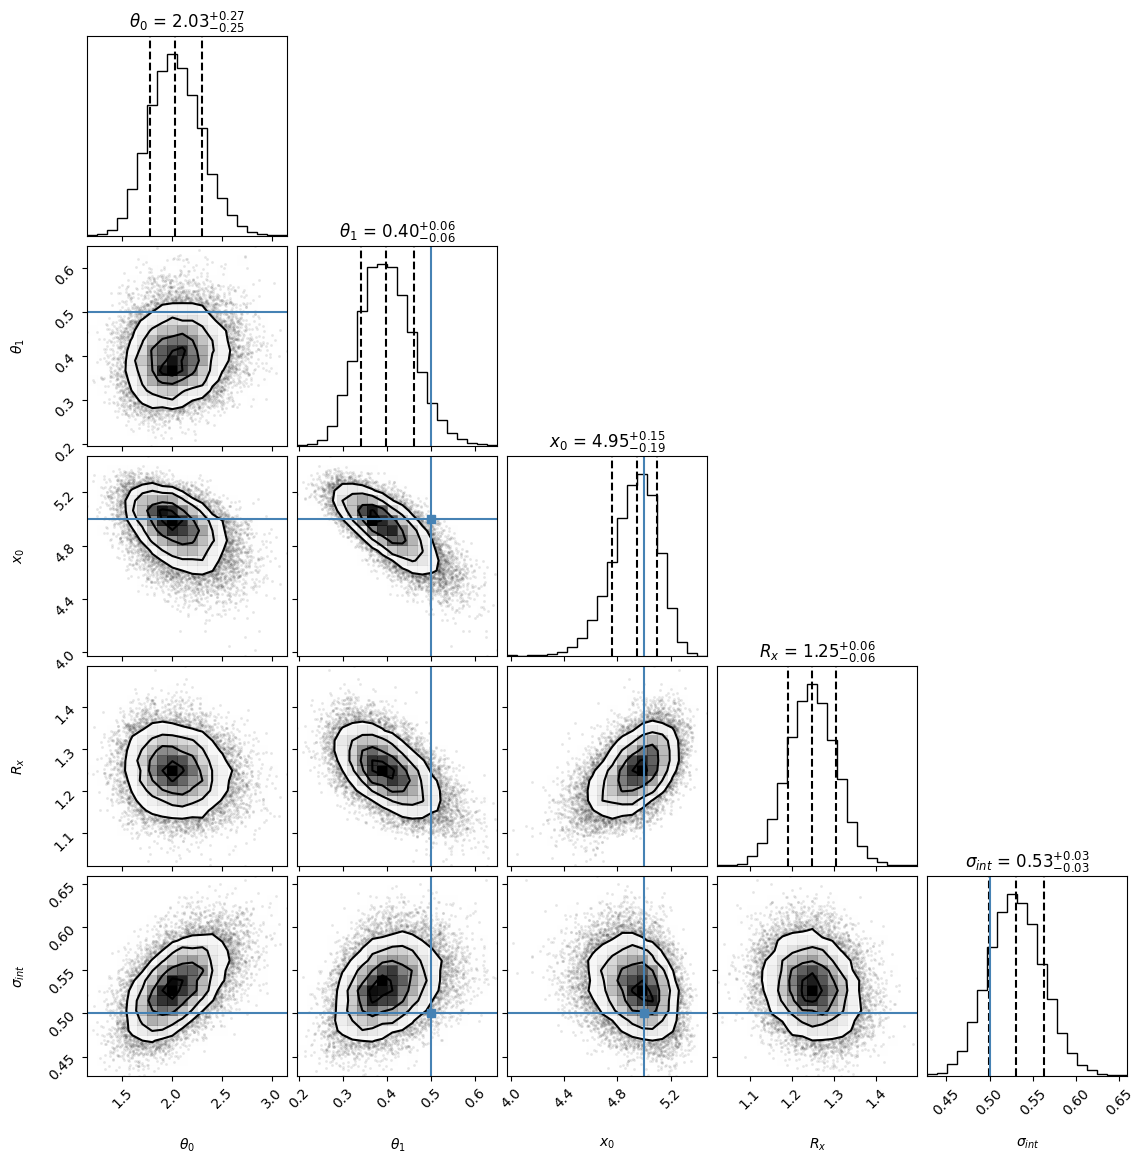

23
67
43


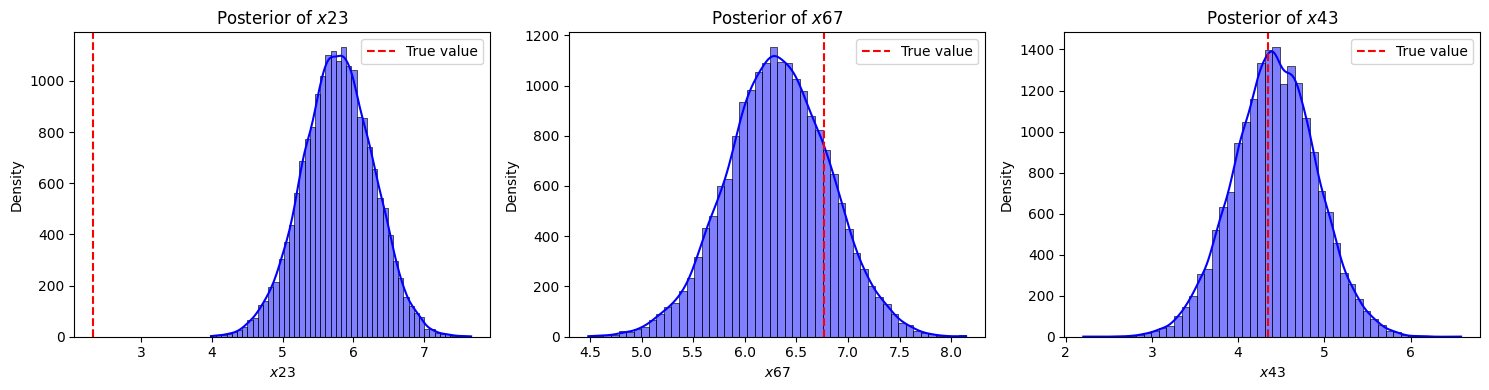

In [101]:
# Plotting with corner
plot_samples = np.vstack([theta_0_samples, theta_1_samples, x0_samples, Rx_samples,sigma_int_samples]).T
labels = [r"$\theta_0$", r"$\theta_1$", r"$x_0$", r"$R_x$", r"$\sigma_{int}$"]
truths = [theta_0_true, theta_1_true, x0_true, Rx_true, sigma_int_true]

figure = corner.corner(
    plot_samples,
    labels=labels,
    truths=truths,
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".2f",
    title_kwargs={"fontsize": 12}
)

plt.show()

# Visualize marginal posteriors for selected x_i
indices = [23, 67, 43]
x_i_samples_selected = x_i_samples[:, indices]
x_i_true_selected = x_true[indices]

num_selected = len(indices)
fig, axes = plt.subplots(1, num_selected, figsize=(5 * num_selected, 4))

for i, idx in enumerate(indices):
    print(idx)
    ax = axes[i] if num_selected > 1 else axes
    sns.histplot(x_i_samples_selected[:, i], bins=50, kde=True, ax=ax, color='blue')
    ax.set_xlabel(f"$x {idx}$")
    ax.set_ylabel("Density")
    ax.set_title(f"Posterior of $x {idx}$")
    ax.axvline(x_i_true_selected[i], color='red', linestyle='--', label='True value')
    ax.legend()

plt.tight_layout()
plt.show()